# CIFAR10: Image Synthesis with GANs

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Fitri|DAAA/FT/2B/06|2222811|
|Ernest|DAAA/FT/2B/06|2222668|



<h5><b> Project Objective </b></h5>
In this project, we will be using the CIFAR10 dataset to create 1000 small colour images through researching and implementing existing GAN architecture and methods to generate new images. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Through online research, we found out that the dataset: 

<br>
<center>

<br>

>  "is a subset of the tiny images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class."
</center>

Therefore, we shall perform checks such that we acquire these values from the dataset during our Exploratory Data Analysis.
<hr>

## 1. Project Setup

### 1.1 Importing Packages and CIFAR-10

In [2]:
#General packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.notebook import tqdm
from IPython.display import clear_output, HTML

#Keras and TensorFlow
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
import visualkeras
from tensorflow.keras.datasets import cifar10
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D


import glob


c:\Users\Admin\miniconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Admin\miniconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

### 1.2 Checking CIFAR-10 Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
n_labels = len(np.unique(y_test))

print(f'Train image shape: {x_train.shape}')
print(f'Test image shape: {y_train.shape}')
print(f'Number of labels: {n_labels}')

170498071/170498071 [==============================] - 24s 0us/step
Train image shape: (50000, 32, 32, 3)
Test image shape: (50000, 1)
Number of labels: 10


## 2. Exploratory Data Analysis

### 2.1 Inspecting Images

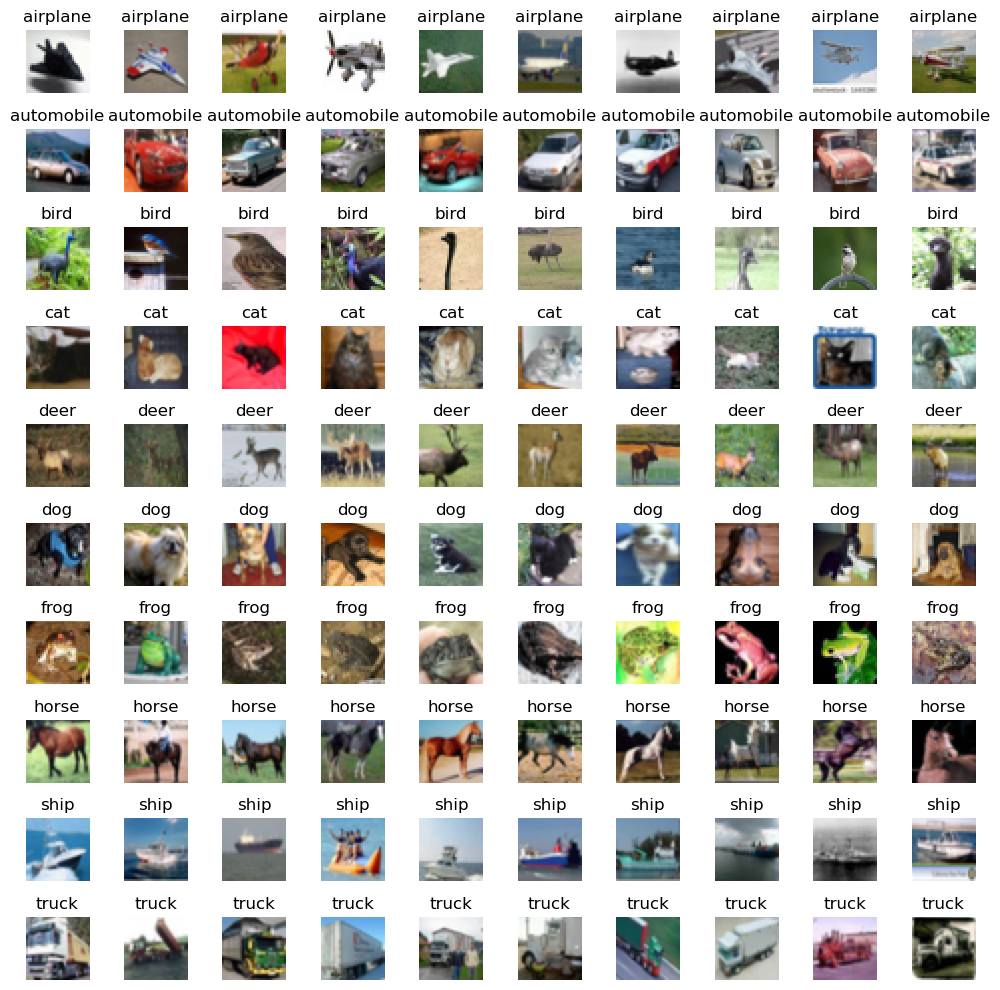

In [4]:
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}


def display_images(images, labels, n_images=10):
    fig, axes = plt.subplots(nrows=n_labels, ncols=n_images, figsize=(10, 10))
    for i in range(n_images):
        for j in range(n_labels):
            axes[j, i].imshow(images[labels.flatten() == j][i])
            axes[j, i].set_title(label_map[j])
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(x_train, y_train)

__Observations:__
- One thing to note from our images is the scaling of different images due to them being all the same 32x32 image size. With cats and dogs being a good example. Where on the 9th image for the cat class, there is a text border on the image of the class. and looking at the dog class, we can only see that head of the dog is in the picture.

### 2.2 Image Averaging
If the images of a certain class are very similar, the average image will look clearer. This is because it contains the same image, and when positioned similarly, the average pixels would be concentrated in the same area for an object. Hence, we shall check the average image of all the classes.

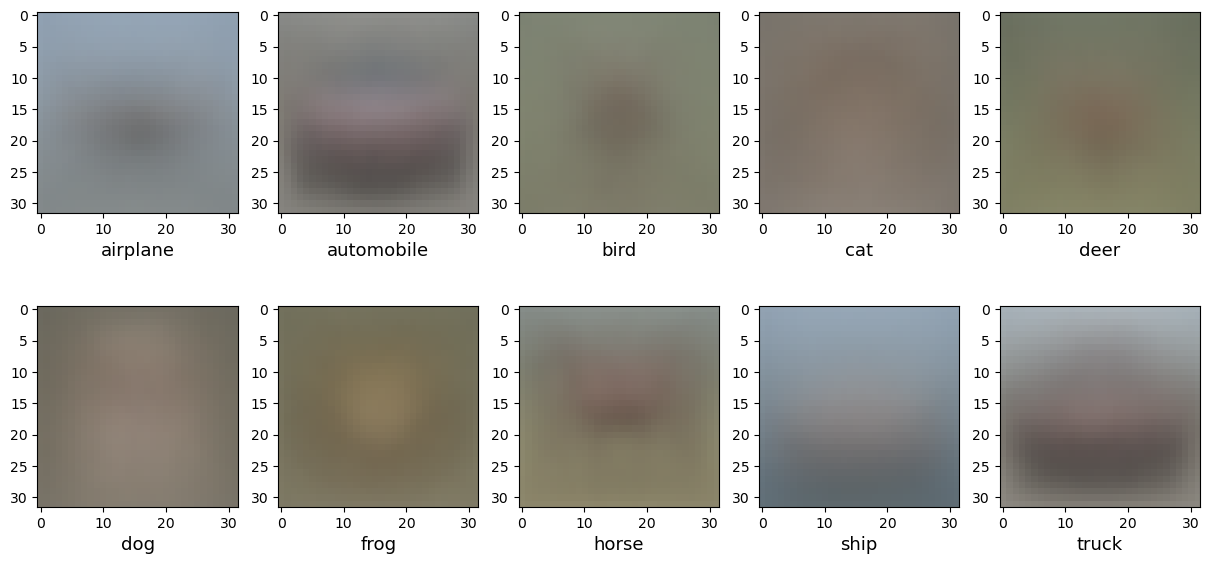

In [5]:
plt.figure(figsize=(15,7))
for i in range(len(label_map)):
    plt.subplot(2,5,i+1)
    mask = (y_train == i).reshape(50000,)
    plt.imshow(np.mean(x_train[mask] / 255, axis=0))
    plt.xlabel(label_map[i], fontsize=13)
plt.show()


__Observations:__
- Some categories like cars and horses show less variety. Even though the average images are a bit blurry, you can still make out cars, horses, and trucks. But for other categories, it's harder to see the average image. This may suggest that generated images for these categories might capture stronger and more accurate features from the training data, making them better than other classes.

### 2.3 Checking Class Distributions

In [6]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{label_map[label]}: {count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


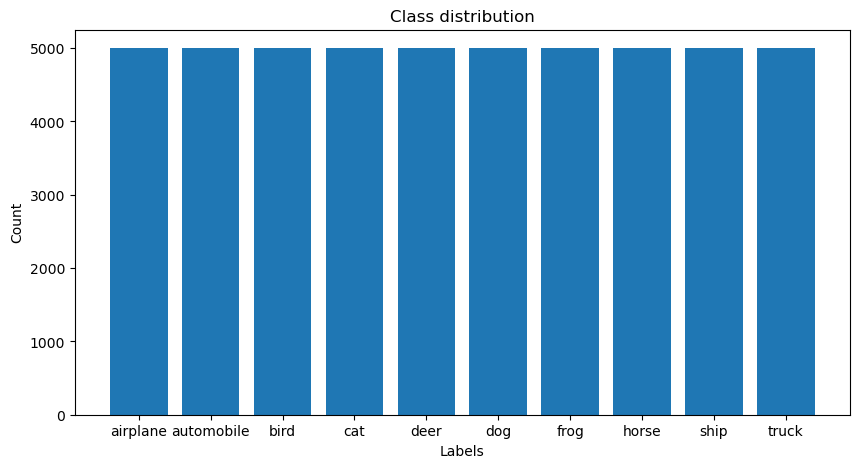

In [7]:
plt.figure(figsize=(10,5))
plt.bar(labels, counts)
plt.xticks(labels, [label_map[label] for label in labels])
plt.title('Class distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show() 

__Observations:__
- We can see that there are no class imbalances in our dataset, thus we do not need to use strategies to combat class imbalances

## 3. Data Preprocessing

### 3.1 One Hot Encoding
As currently our labels are encoded from 0-10, we will one hot encode the labels.

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(f'Label: {y_train[0]}')

Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 3.2 Normalizing
By normalizing, we adjust the pixel values of our images to be between 0 and 1. This uniformity helps our models learn faster and perform better. To do this, we calculate the mean and standard deviation of the training data and use a formula to modify each input accordingly:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [12]:
preprocessing = Normalization()
preprocessing.adapt(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


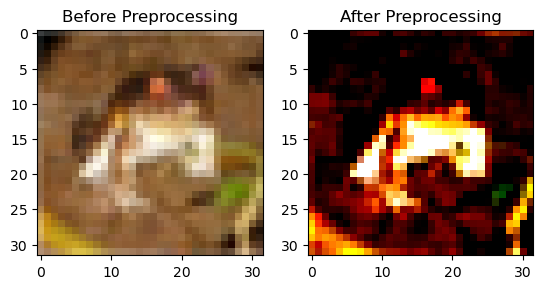

In [13]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(x_train[0])
ax[0].set_title('Before Preprocessing')
ax[1].imshow(tf.squeeze(preprocessing(x_train[:1, :, :])))
ax[1].set_title('After Preprocessing')
plt.show()

In [14]:
x_train = x_train.astype('float32')
x_train /= (255/2)
x_train -= 1

### 3.3 Data Augmentation
Data augmentation is a widely used technique in deep learning to mitigate overfitting by introducing random transformations to images, thereby creating diverse variations. In our project, the aim is to address overfitting in the discriminator. The presence of an overfitted discriminator, as highlighted in Karras et al.'s paper "Training Generative Adversarial Networks with Limited Data,"[[]](https://arxiv.org/abs/2006.06676) can result in a deterioration of the generated image quality.

However, a drawback from using data augmentation on training GANs is that it could mislead the generator to learn the distribution of the augmented data, which could be different from that of the original data. As mentioned in the paper "On Data Augmentation for GAN Training" by Ngoc-Trung Tran [[]](https://arxiv.org/pdf/2006.05338.pdf).
> "Some transformed data could be infrequent or non-existence w.r.t. the original data distribution (Pd(T(x)) ≈ 0, where T(x) is some transformed data by a transformation T). On the other hand, augmenting the dataset may mislead the generator to learn to generate these transformed data. For example, if rotation is used for data augmentation on a dataset with category “horses”, the generator may learn to create rotated horses, which could be inappropriate in some applications."

Thus we will avoid the use of Data Augmentation for now.

# 4. Models

#### We will be comparing these models
- DCGAN (Baseline)
- ACGAN
- CGAN
### How exaclty does a GAN work?

### How do we evaluate our models?
- evulataion metrics

### What do we need to keep in mind?

### Parameters (Batch Size)

## 4.1 Baseline Model

## 4.2 Model Selection

## 6. Evaluation

## 7. Conclusions

<hr>

## References